<a href="https://colab.research.google.com/github/yasinsoylu1997/64-64-UnderSampler/blob/main/hybr%C4%B1t_models__64*64128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import time
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 64
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:04<00:00, 286.40it/s]


In [5]:
from imblearn.under_sampling import RandomUnderSampler 
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,64,64,3)
oversampled_y


array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

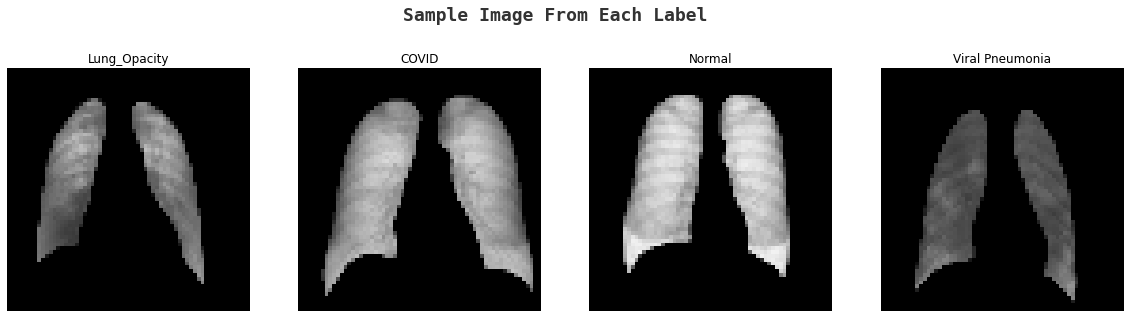

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

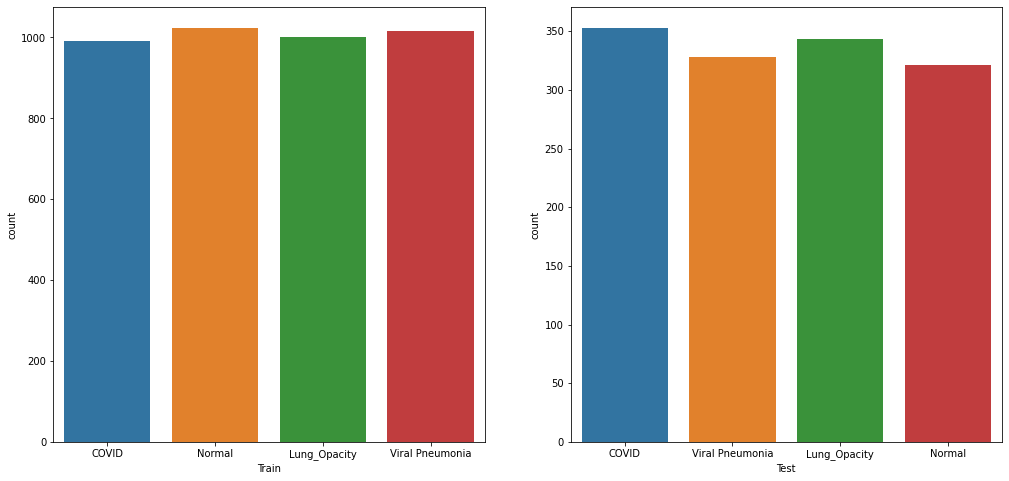

In [8]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [11]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [14]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(128, 3, activation = activation, padding = 'same', input_shape = (64, 64, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=(3, 3)))

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [15]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

In [16]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0     

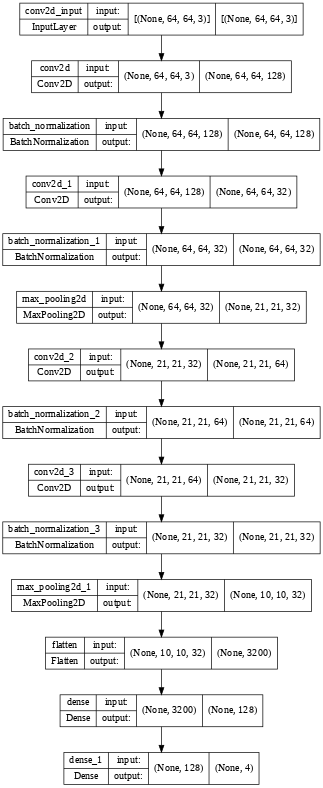

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

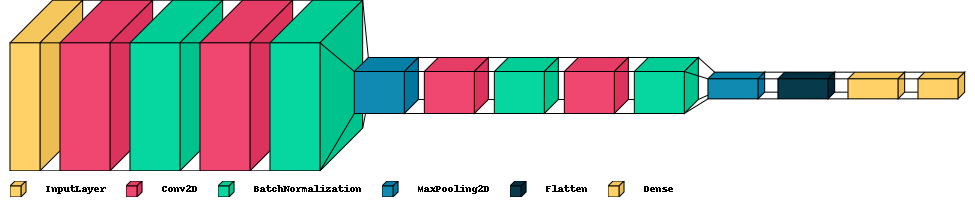

<Figure size 144x144 with 0 Axes>

In [18]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(cnn_model, legend=True,spacing=20,scale_xy = 2 , scale_z = 10, max_z = 50) 

In [19]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, min_delta = 0.0001,mode='auto',verbose=1)
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_accuracy",patience=5,verbose=1,mode="auto",)

In [20]:
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot),batch_size=8,callbacks=[checkpoint,reduce_lr,early_stop])

Epoch 1/50
505/505 [==============================] - ETA: 0s - loss: 0.9463 - accuracy: 0.6198
Epoch 1: val_accuracy improved from -inf to 0.49888, saving model to cnn.h5
505/505 [==============================] - 7s 9ms/step - loss: 0.9463 - accuracy: 0.6198 - val_loss: 0.9566 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/50
500/505 [============================>.] - ETA: 0s - loss: 0.6991 - accuracy: 0.7003
Epoch 2: val_accuracy improved from 0.49888 to 0.68030, saving model to cnn.h5
505/505 [==============================] - 4s 8ms/step - loss: 0.6991 - accuracy: 0.7006 - val_loss: 0.7592 - val_accuracy: 0.6803 - lr: 0.0010
Epoch 3/50
499/505 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.7317
Epoch 3: val_accuracy improved from 0.68030 to 0.72714, saving model to cnn.h5
505/505 [==============================] - 4s 8ms/step - loss: 0.6212 - accuracy: 0.7311 - val_loss: 0.6496 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 4/50
499/505 [==========================

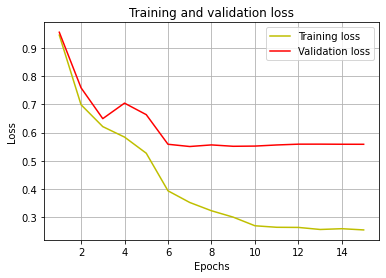

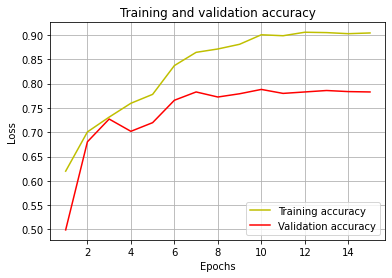

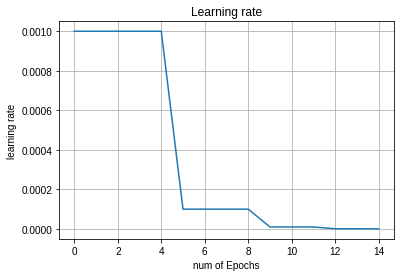

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

nb_epoch = len(history.history['loss'])
learning_rate=history.history['lr']
xc=range(nb_epoch)
plt.plot(xc,learning_rate)
plt.xlabel('num of Epochs')
plt.ylabel('learning rate')
plt.title('Learning rate')
plt.grid(True)
plt.style.use(['seaborn-ticks'])

In [22]:
from keras.models import load_model

cnn_model = load_model('cnn.h5')

In [23]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

[[235  59  58   1]
 [ 39 258  41   5]
 [ 44  17 253   7]
 [  4   4   6 314]]


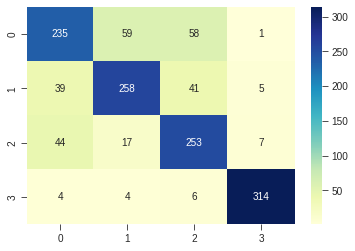

In [24]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [25]:
#Now, let us use features from convolutional network for ML
X_for_model = feature_extractor.predict(x_train) 

In [26]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy_mymodel', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

#  KNeighborsClassifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [28]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = knn_model.predict(X_test_feature)

In [29]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.38438661710037175
MSE: 0.6133828996282528
RMSE: 0.7831876528829171
R2 Square 0.5137050057980694
Accuracy_mymodel 0.7256505576208179
__________________________________


In [30]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651


In [31]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       353
           1       0.69      0.65      0.67       343
           2       0.64      0.74      0.69       321
           3       0.95      0.90      0.93       328

    accuracy                           0.73      1345
   macro avg       0.73      0.73      0.73      1345
weighted avg       0.73      0.73      0.73      1345



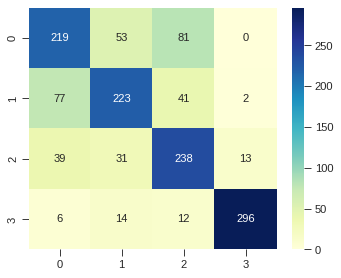

In [32]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [34]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = cart_model.predict(X_test_feature)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.625278810408922
MSE: 1.0921933085501858
RMSE: 1.0450805273040857
R2 Square 0.13410018608165342
Accuracy_mymodel 0.5769516728624535
__________________________________


In [35]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952


In [36]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.47      0.46      0.47       353
           1       0.54      0.50      0.52       343
           2       0.51      0.56      0.53       321
           3       0.80      0.79      0.80       328

    accuracy                           0.58      1345
   macro avg       0.58      0.58      0.58      1345
weighted avg       0.58      0.58      0.58      1345



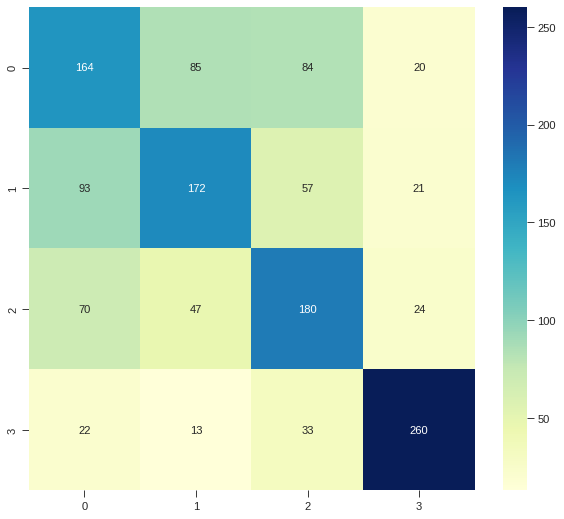

In [37]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [38]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [39]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = lr_model.predict(X_test_feature)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3486988847583643
MSE: 0.5672862453531599
RMSE: 0.7531840713618152
R2 Square 0.5502508114229419
Accuracy_mymodel 0.7531598513011153
__________________________________


In [40]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160


In [41]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       353
           1       0.71      0.72      0.72       343
           2       0.68      0.70      0.69       321
           3       0.95      0.94      0.94       328

    accuracy                           0.75      1345
   macro avg       0.76      0.76      0.76      1345
weighted avg       0.75      0.75      0.75      1345



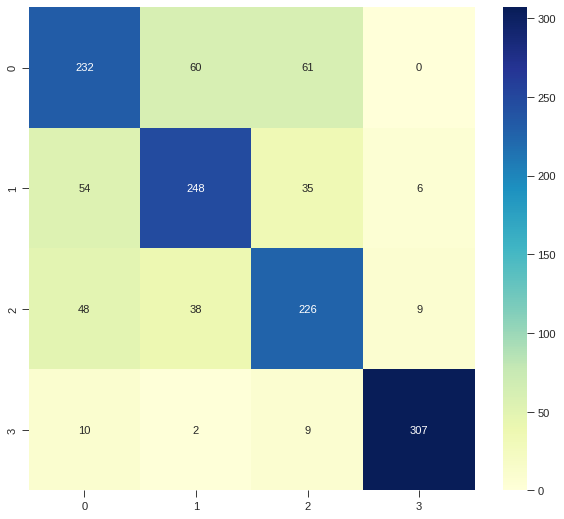

In [42]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [43]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [44]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = LGBM_model.predict(X_test_feature)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.30557620817843867
MSE: 0.4944237918215613
RMSE: 0.7031527514143433
R2 Square 0.608016762249353
Accuracy_mymodel 0.7836431226765799
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643


In [46]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       353
           1       0.74      0.76      0.75       343
           2       0.73      0.78      0.75       321
           3       0.94      0.93      0.93       328

    accuracy                           0.78      1345
   macro avg       0.79      0.79      0.79      1345
weighted avg       0.78      0.78      0.78      1345



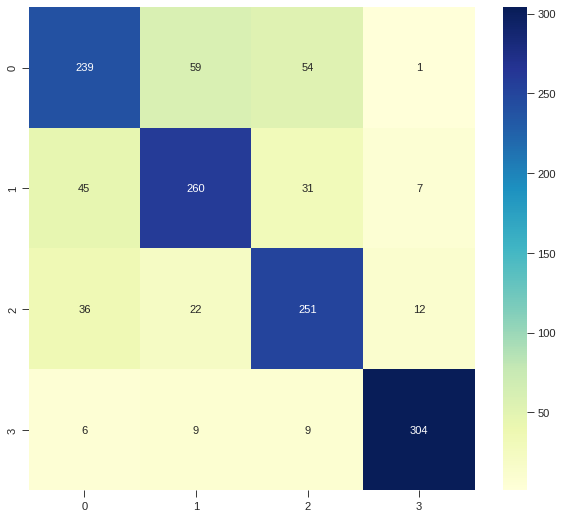

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [49]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = rf_model.predict(X_test_feature)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3479553903345725
MSE: 0.5799256505576208
RMSE: 0.7615284962216586
R2 Square 0.540230187299993
Accuracy_mymodel 0.758364312267658
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643
4,RandomForestClassifier,0.347955,0.579926,0.761528,0.540230,0.758364


In [52]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       353
           1       0.72      0.74      0.73       343
           2       0.72      0.72      0.72       321
           3       0.93      0.93      0.93       328

    accuracy                           0.76      1345
   macro avg       0.76      0.76      0.76      1345
weighted avg       0.76      0.76      0.76      1345



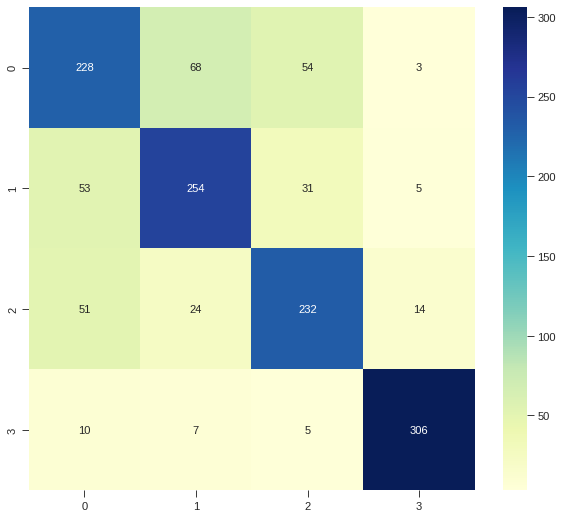

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [54]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [55]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GB_model.predict(X_test_feature)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.48698884758364314
MSE: 0.7903345724907063
RMSE: 0.8890076335390525
R2 Square 0.3734162680767853
Accuracy_mymodel 0.6624535315985131
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643
4,RandomForestClassifier,0.347955,0.579926,0.761528,0.540230,0.758364
5,GaussianNB,0.486989,0.790335,0.889008,0.373416,0.662454


In [58]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       353
           1       0.63      0.67      0.65       343
           2       0.54      0.74      0.62       321
           3       0.92      0.90      0.91       328

    accuracy                           0.66      1345
   macro avg       0.67      0.67      0.66      1345
weighted avg       0.67      0.66      0.65      1345



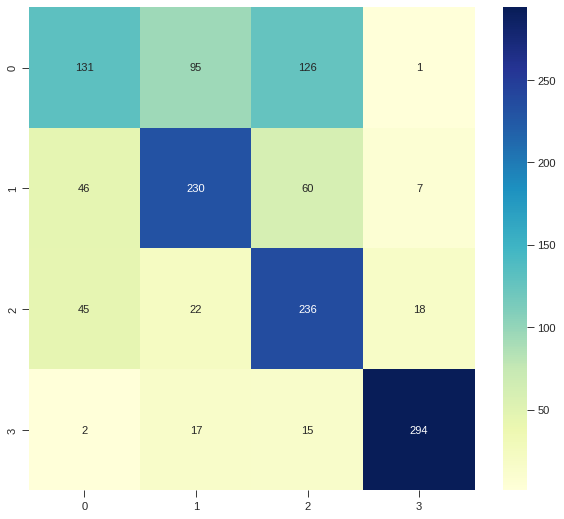

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [60]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [61]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = SGD_model.predict(X_test_feature)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3687732342007435
MSE: 0.5799256505576208
RMSE: 0.7615284962216586
R2 Square 0.540230187299993
Accuracy_mymodel 0.729368029739777
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643
4,RandomForestClassifier,0.347955,0.579926,0.761528,0.540230,0.758364
5,GaussianNB,0.486989,0.790335,0.889008,0.373416,0.662454
6,SGDClassifier,0.368773,0.579926,0.761528,0.540230,0.729368


In [64]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       353
           1       0.64      0.75      0.69       343
           2       0.69      0.65      0.67       321
           3       0.97      0.93      0.95       328

    accuracy                           0.73      1345
   macro avg       0.74      0.73      0.73      1345
weighted avg       0.73      0.73      0.73      1345



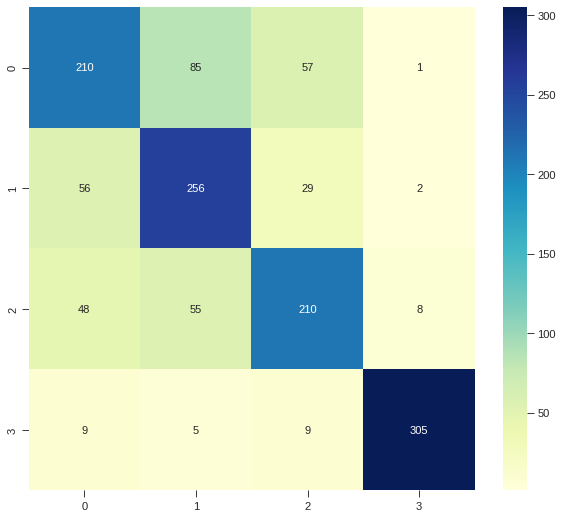

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# svc

In [66]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [67]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svm_model.predict(X_test_feature)

In [68]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.379182156133829
MSE: 0.6230483271375464
RMSE: 0.7893341036199731
R2 Square 0.5060421755864026
Accuracy_mymodel 0.7330855018587361
__________________________________


In [69]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643
4,RandomForestClassifier,0.347955,0.579926,0.761528,0.540230,0.758364
5,GaussianNB,0.486989,0.790335,0.889008,0.373416,0.662454
6,SGDClassifier,0.368773,0.579926,0.761528,0.540230,0.729368
7,SVC,0.379182,0.623048,0.789334,0.506042,0.733086


In [70]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       353
           1       0.70      0.68      0.69       343
           2       0.68      0.70      0.69       321
           3       0.96      0.92      0.94       328

    accuracy                           0.73      1345
   macro avg       0.74      0.74      0.74      1345
weighted avg       0.74      0.73      0.73      1345



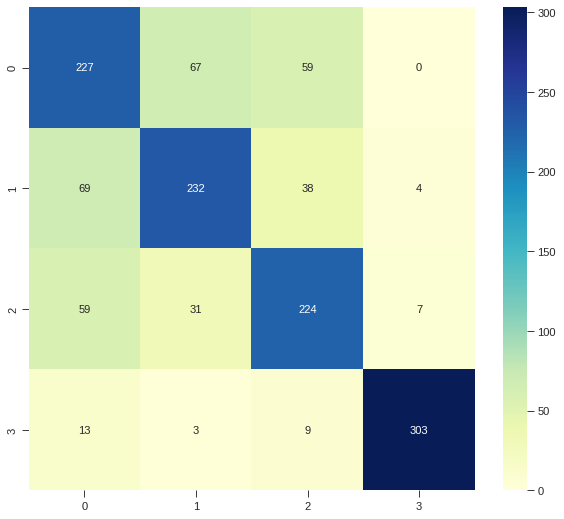

In [71]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [72]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]

In [73]:
from sklearn.metrics import accuracy_score
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_mymodel"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_feature)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_mymodel"])
    sonuclar = sonuclar.append(sonuc)

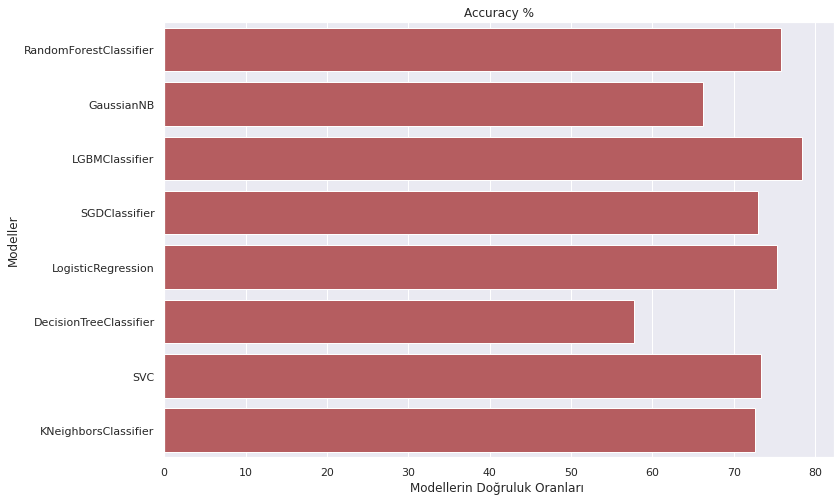

In [74]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_mymodel', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy %');




In [75]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.384387,0.613383,0.783188,0.513705,0.725651
1,DecisionTreeClassifier,0.625279,1.092193,1.045081,0.134100,0.576952
2,LogisticRegression,0.348699,0.567286,0.753184,0.550251,0.753160
3,LGBMClassifier,0.305576,0.494424,0.703153,0.608017,0.783643
4,RandomForestClassifier,0.347955,0.579926,0.761528,0.540230,0.758364
5,GaussianNB,0.486989,0.790335,0.889008,0.373416,0.662454
6,SGDClassifier,0.368773,0.579926,0.761528,0.540230,0.729368
7,SVC,0.379182,0.623048,0.789334,0.506042,0.733086


In [76]:
best_acc=sonuclar.sort_values(by=['Accuracy_mymodel'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model


,Modeller,Accuracy_mymodel
0,LGBMClassifier,78.364312


In [77]:
from google.colab import files

results_df.to_csv('output_mymodel.csv', encoding = 'utf-8-sig') 
files.download('output_mymodel.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>